## Setup

In [ ]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import tensorflow as tf
import numpy as np
from PIL import Image
import keras
from keras.applications.inception_v3 import InceptionV3
from keras.applications.resnet50 import ResNet50
from keras.applications.xception import Xception
from keras.applications.vgg16 import VGG16
from keras import backend as K
from scipy.ndimage.filters import gaussian_filter
from IPython.display import clear_output, HTML
from IPython.display import display, Image
from functools import partial


import utils; reload(utils)
from utils import *
from IPython.core.debugger import Tracer

%matplotlib inline

In [2]:
# Prepare a tensor to be displayed as image
def normalize(x):
    x = x.copy().astype(float)
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    return x.astype('uint8')

def show(a, fmt='jpeg'):
    f = BytesIO()
    PIL.Image.fromarray(a.astype('uint8')).save(f, fmt)
    img = Image(data=f.getvalue())
    display.display(img)

def resize_array(array, size):
    '''Resizes an image (formatted as np array) to give size.
    Args:
        array: np array representing the image.
        size: The desired size.
    Returns: The resized image as a float np array.
    '''
    image = PIL.Image.fromarray(array.astype('uint8').copy())
    image_resized = image.resize(size, PIL.Image.ANTIALIAS)
    return np.asarray(image_resized).astype(float)

In [30]:
# DPI of monitor (for matplotlib)
dpi = 80

image_size = (960, 720)
channels = 3 # 3 for color image, 1 for grayscale
tile_size = (299, 299)

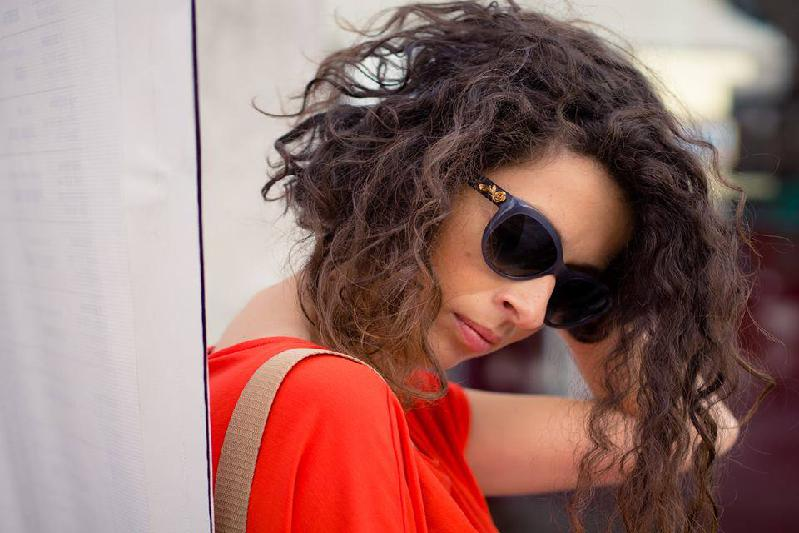

(533, 799, 3)

In [49]:
def get_image(size, random_noise=None, filename=None):
    '''Generate or load an image and return it as np array. 
        Args:
            size: The desired dimensions of the output image.
            random_noise: Whether to generate a random noise 
             image or to load a picture.
            filename: The fullpath to the image to load.
    '''
    width, height = size
    
    if not random_noise:
        random_noise = False

    if random_noise:
        # Generate a random noise image
        img = np.random.random(size=(width, height, 3))
        img_array = img * 256 
        
        # Another way to generate randomness (could be useful)
        #img = np.random.random(size=(width, height, 3))
        #img_array = (img - 0.5) * 20 + 128
        
        # A third way to generate random images
        #img_array = np.zeros(shape=(width, height, 3)) + 100.0
    else:
        if not filename:
            raise ValueError('If not generating random noise image, image filename is required.')
        # Load a picture
        img = PIL.Image.open(filename)
        img = img.resize((width, height))
        img_array = np.asarray(img.copy())

    return img_array

image = get_image(size=image_size, random_noise=False, filename='didi.jpg')
show(image)
image.shape

In [50]:
class Inception5h(object):
    def __init__(self, input_tensor, normalize=True):
        model_fn = 'inception/5h/tensorflow_inception_graph.pb'
        # creating TensorFlow session and loading the model
        with tf.gfile.FastGFile(model_fn, 'rb') as f:
            graph_def = tf.GraphDef()
            graph_def.ParseFromString(f.read())

        tf.import_graph_def(graph_def, {'input':input_tensor})

In [6]:
def setup_model(normalize_input=False, model_name='Inception5h'):
    '''Load the model. Use a TF tensor as input just for fun.
    Args: 
        tile_size: The dimensions of a single tile.
        normalize_input: Whether to normalize the input image.
    '''
    # Prepare tensor for input image
    graph = tf.Graph()
    with graph.as_default():
        image_tensor = tf.placeholder(
            dtype=tf.float32, 
            #shape=(1, None, None, 3),
            name='input')

        if normalize_input:
            # Normalize input image
            input_normalized = tf.image.per_image_standardization(image_tensor)
            # Add a batch dimension to the image (required by keras model)
            input_batch = tf.expand_dims(input_normalized, axis=0)
            input_tensor = input_batch
            
            # Another way to normalize the input
            #imagenet_mean = 117.0
            #input_minus_mean = tf.squeeze(image_tensor, 0) - imagenet_mean
            #input_normalized = tf.expand_dims(input_minus_mean, axis=0)
            #input_tensor = input_normalized
        else:
            input_tensor = image_tensor
        if model_name == 'Inception5h':
            Inception5h(input_tensor)
            model = graph
        elif model_name == 'InceptionV3':
            model = InceptionV3(include_top=False, weights='imagenet', 
                           input_tensor=input_tensor)
    
    input_tensor = image_tensor
    return model, input_tensor

model, input_tensor = setup_model(normalize_input=True)
# model.summary()

K.set_learning_phase(0)
sess = tf.InteractiveSession(graph=model)
K.set_session(sess)

#print(input_tensor)
#print([op.name for op in model.get_operations()])

In [7]:
def setup_gradient(input_tensor, result_tensor):
    '''Setup the gradient tensor of the input tensor w.t.r 
    to the result tensor.
    Args: 
        input_tensor: The input features tensor.
        result_tensor: The tensor that we want to maximize.
    '''
    # First get the result mean
    excitement_score = tf.reduce_mean(result_tensor)

    # Gradients give us how to change the input (input_tensor) 
    # to increase the excitement_score.
    gradient = tf.gradients(excitement_score, input_tensor)[0]
    # normalize the gradient by its L2 norm
#     gradient /= (tf.sqrt(tf.reduce_mean(tf.square(gradient))) 
#                                 + 1e-5)

    return gradient, excitement_score

In [8]:
# Slice an image into tiles so that we can process 
# larger images with limited GPU memory.
def get_tile_coordinates(max_size, tile_size):
    ''' Generate tile coordinates for image.
    Args:
        max_size: The dimensions of the whole image.
        tile_size: The dimensions of a single tile.

    '''
    master_width, master_height = max_size
    tile_width, tile_height = tile_size
    
    tiles = []
    for x in range(0, master_width, tile_width):
        for y in range (0, master_height, tile_height):
            tile_x1 = x
            tile_y1 = y
            tile_x2 = x + tile_width
            tile_y2 = y + tile_height

            # If we dont have enough pixels for a full tile, 
            # slide the tile a bit into the previous one.
            # This is done because we want to process all 
            # parts of the image.
            if tile_x2 > master_width:
                continue;
#                 tile_x1 = master_width - tile_width
#                 tile_x2 = master_width 
            if (tile_y2 > master_height):
                continue
#                 tile_y1 = master_height - tile_height
#                 tile_y2 = master_height 
                
            tile = (tile_x1,tile_y1,tile_x2,tile_y2)
            tiles.append(tile)
    return tiles

def add_randomness_to_tile(tile_coordinates, max_size, randomness_factor=0.1):
    ''' Generate randomness in the x and y coords 
        so that we dont get seams between the tiles.
        Args:
            tile_coordinates: A tupple of (x1,y1,x2,y2) coords
                for the tile.
            max_size: The dimension of the master image.
            randomness_factor: How much to change the tile_coords. This
                is a fraction between [0,1].
    '''
    x1,y1,x2,y2 = tile_coordinates
    tile_width = x2-x1
    tile_height = y1-y2
    max_x, max_y = max_size
    
    # Calculate the random change in x and y.
    rand_x = int((tile_width*randomness_factor*
                  (np.random.random()-0.5)*2))
    rand_y = int((tile_height*randomness_factor*
                  (np.random.random()-0.5)*2))
    # check if the new coords will go outside the max range
    if (x1 + rand_x < 0) or (x2 + rand_x > max_x):
        rand_x = 0
    if (y1 + rand_y < 0) or (y2 + rand_y > max_y):
        rand_y = 0

    x1 += rand_x
    x2 += rand_x
    y1 += rand_y
    y2 += rand_y

    return x1,y1,x2,y2

Laplacian pyramide normalization (code from https://nbviewer.jupyter.org/github/tensorflow/tensorflow/blob/master/tensorflow/examples/tutorials/deepdream/deepdream.ipynb#laplacian)

In [9]:
k = np.float32([1,4,6,4,1])
k = np.outer(k, k)
k5x5 = k[:,:,None,None]/k.sum()*np.eye(3, dtype=np.float32)

def lap_split(img):
    '''Split the image into lo and hi frequency components'''
    with tf.name_scope('split'):
        lo = tf.nn.conv2d(img, k5x5, [1,2,2,1], 'SAME')
        lo2 = tf.nn.conv2d_transpose(lo, k5x5*4, tf.shape(img), [1,2,2,1])
        hi = img-lo2
    return lo, hi

def lap_split_n(img, n):
    '''Build Laplacian pyramid with n splits'''
    levels = []
    for i in range(n):
        img, hi = lap_split(img)
        levels.append(hi)
    levels.append(img)
    return levels[::-1]

def lap_merge(levels):
    '''Merge Laplacian pyramid'''
    img = levels[0]
    for hi in levels[1:]:
        with tf.name_scope('merge'):
            img = tf.nn.conv2d_transpose(img, k5x5*4, tf.shape(hi), [1,2,2,1]) + hi
    return img

def normalize_std(img, eps=1e-10):
    '''Normalize image by making its standard deviation = 1.0'''
    with tf.name_scope('normalize'):
        std = tf.sqrt(tf.reduce_mean(tf.square(img)))
        return img/tf.maximum(std, eps)

def lap_normalize(img, scale_n=4):
    '''Perform the Laplacian pyramid normalization.'''
    img = tf.expand_dims(img,0)
    tlevels = lap_split_n(img, scale_n)
    tlevels = list(map(normalize_std, tlevels))
    out = lap_merge(tlevels)
    return out[0,:,:,:]

def tffunc(*argtypes):
    '''Helper that transforms TF-graph generating function into a regular one.
    See "laplacian_normalize" function below.
    '''
    placeholders = list(map(tf.placeholder, argtypes))
    def wrap(f):
        out = f(*placeholders)
        def wrapper(*args, **kw):
            return out.eval(dict(zip(placeholders, args)), session=kw.get('session'))
        return wrapper
    return wrap

lap_n=4
lap_norm_func = tffunc(np.float32)(partial(lap_normalize, scale_n=lap_n))


In [10]:
def gaussian_blur_normalization(gradient, sigma):
    grad_smooth1 = gaussian_filter(gradient, sigma=sigma*0.5)
    grad_smooth2 = gaussian_filter(gradient, sigma=sigma*1)
    grad_smooth3 = gaussian_filter(gradient, sigma=sigma*2)
    return (gradient + grad_smooth1 + 
            grad_smooth2 + grad_smooth3) / 4

In [37]:
def calculate_gradient(input_array, gradient_tensor, 
                       score_tensor, input_tensor):
    '''Calculate the gradient.
    Args: 
        input_array: An 3d np array with the input image.
        gradient_tensor: Gradient computation tensor.
        score_tensor: Score of how much gradient_tensor activates.
        input_tensor: The tensor where the input_array should be fed.
        '''
    # Add a batch dimension to the image
    #input_batch = np.expand_dims(input_array, axis=0)
    # Compute the gradient and the loss
    gradient_computed, score_computed = sess.run(
        [gradient_tensor, score_tensor], 
        feed_dict={input_tensor: input_array})
    # Add gradient to image to feed back into the model
    return np.squeeze(gradient_computed), score_computed


def run_update_on_tiles(image, tile_size, 
                        iterations, step,
                        color_preservation_factor,
                        gradient_tensor, score_tensor,
                        input_tensor):
    '''Separate image in tiles and run gradient update on them,
        to maximize the activations of gradient_tensor, 
        as measured by score tensor.
    Args:
        image: An 3d np array with the image to update
        tile_size: Size of a single tile.
        iterations: How many times to process each tile.
        step: How strong should the gradient update be
        color_preservation_factor: How much of the original 
            colors should be preserved vs the psychedelic 
            colors of dreaming.
        gradient_tensor: Gradient computation tensor.
        score_tensor: Score of how much gradient_tensor activates.
        input_tensor: The tensor where the input_array should be fed.
    '''
    max_size = image.shape[:2]
    
    roll_image = True
    if roll_image:    
        # We are going to shift the image in x and y a random 
        # amount. np.roll places elements that are be outside 
        # the image at the other side.
        x_roll = np.random.randint(image.shape[0])
        y_roll = np.random.randint(image.shape[1])
        image = np.roll(
            np.roll(image, x_roll, axis=0), 
            y_roll, axis=1)

    # We will the history of how each tile changes here.
    tile_history = []

    # Generate the tile coordinates
    tiles = get_tile_coordinates(max_size, tile_size)

    # Process each tile and then sew them together
    print('\nIteration (total: {}): '.format(len(tiles)*iterations), end=' ')
    for iteration_index in range(iterations):
        # Keep the current gradient here.
        gradient = np.zeros(image.shape)
        # Compute the gradient over the whole image, 
        # by tiling over it.
        for tile_index, tile_coordinates in enumerate(tiles):
            # Print the number of the current iteration as 
            # a progress indicator.
            current_iteration = (iteration_index * len(tiles)
                                 + tile_index + 1)
            print(current_iteration, end=' ')
            # Randomize the tile coords to prevent seams
            # between tiles.
            x1,y1,x2,y2 = add_randomness_to_tile(
                tile_coordinates=tile_coordinates,
                max_size=max_size,
                randomness_factor = 0.1)
            
            # Use this tile from the input image.
            input_image = image[x1:x2, y1:y2]
            
            # Compute the gradient (and score if needed for debug).
            gradient_computed, score_computed = calculate_gradient(
                input_image, gradient_tensor,
                score_tensor, input_tensor)
            
            # Keep the computed gradient in the gradient map
            gradient[x1:x2, y1:y2] += gradient_computed
            
            # If debugging of the score is needed.
            #print('({:.1f})'.format(score_computed), end=' ')
            
        # Blur the gradient, preserving more of the original image colors.
        # sigma increases from [1, 8.2] before scaling with
        # color_preservation_factor.
        sigma = ( (iteration_index * 4.0 / iterations + 0.5) * 2
                 * color_preservation_factor)
        if color_preservation_factor:
            gradient = gaussian_blur_normalization(
                gradient, sigma)

        # Uncomment this to display the gradient itself
        # show(normalize(gradient_computed))

        # Normalize gradient 
        #gradient = lap_norm_func(gradient)
        gradient /= (gradient.std() + 1e-8)
        
        # Scale by step.
        gradient *= step
        
        # Alter the input image by gradient, changing it 
        # to please the neurons we chose.
        image = image + gradient
        image = np.clip(image, 0, 255)
        
    if roll_image:    
        # Unroll the image back to normal.
        image = np.roll(
            np.roll(image, -x_roll, axis=0), 
            -y_roll, axis=1)
    return image, tile_history

def multilevel_dream(image, tile_size, 
                     gradient_tensor,
                     score_tensor,
                     input_tensor,
                     scale_factor = 1.4,
                     color_preservation_factor=0.5,
                     iterations=10, step=5, 
                     levels=3, 
                     blending_factor=0.5):
        ''' Create a deep dream by applying the algo at several different levels.
        Args:
            image: An 3d np array with the image to update
            tile_size: Size of a single tile.
            gradient_tensor: Gradient computation tensor.
            score_tensor: Score of how much gradient_tensor activates.
            input_tensor: The tensor where the input_array should be fed.            
            scale_factor: How much to resize with each level.
            color_preservation_factor: How much of the original 
                colors should be preserved vs the psychedelic 
                colors of dreaming. Higher values preserve more 
                of the original colors. Between [0,1], 0.5 by default. 
            iterations: How many times to process each tile.
            step: How strong should the gradient update be
            levels: How deep to dream.
            blending_factor: How much of the original image to keep (0 to 1).
                Lower values result in more psychedelic images. Default 0.5.
        '''
        img = image.copy()
        # We need (width, height) and they are reversed in np: (rows, columns)
        original_size = (img.shape[1], img.shape[0])

        tile_history = []

        # This is the smallest size we are going to process
        # this image in. Since we start with it and scale up,
        # we compute it now.
        smallest_size = np.array(original_size)
        # For each level but the last (where we use the original 
        # size), scale down once
        for level in range(levels):
            smallest_size = smallest_size / scale_factor
        

        for level in range(levels):    
#             resize_to = smallest_size * (level+1) * scale_factor
            resize_to = (tile_size[0]*(level+1), tile_size[1]*(level+1))
#             resize_to = resize_to * scale_factor
            resized_img = resize_array(img, resize_to)
            
            update_image, tile_history_level = run_update_on_tiles(
                resized_img, tile_size, 
                iterations, step, 
                color_preservation_factor,
                gradient_tensor, score_tensor,
                input_tensor)

            tile_history.append(tile_history_level)

            update_image = resize_array(update_image, original_size)
            # Keep part of the original image
            img = blending_factor * img + (1.0 - blending_factor) * update_image
        return img, tile_history

## Display Graph

In [33]:
layers = [op.name for op in model.get_operations() if op.type=='Conv2D' and 'import/' in op.name]
feature_nums = [int(model.get_tensor_by_name(name+':0').get_shape()[-1]) for name in layers]

print('Number of layers', len(layers))
print('Total number of feature channels:', sum(feature_nums))


# Helper functions for TF Graph visualization

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = bytes("<stripped %d bytes>"%size)
    return strip_def
  
def rename_nodes(graph_def, rename_func):
    res_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = res_def.node.add() 
        n.MergeFrom(n0)
        n.name = rename_func(n.name)
        for i, s in enumerate(n.input):
            n.input[i] = rename_func(s) if s[0]!='^' else '^'+rename_func(s[1:])
    return res_def
  
def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))
  
    iframe = """
        <iframe seamless style="width:800px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    html = HTML(iframe)
    display.display(html)

# Visualizing the network graph. Be sure expand the "mixed" nodes to see their 
# internal structure. We are going to visualize "Conv2D" nodes.
tmp_def = rename_nodes(model.as_graph_def(), lambda s:"/".join(s.split('_',1)))
#show_graph(tmp_def)

Number of layers 59
Total number of feature channels: 7548


## Dreaming with other networks

In [59]:
# Set the layer/neuron to excite
# output_tensor = model.layers[-1].output
#output_tensor = model.get_layer( 
    #'block5_conv3').output[:,:,:,320] #VGG
    #'convolution2d_188').output[:,:,:,:] # Xception - Not working
    #'convolution2d_92').output[:,:,:,:] #InceptionV3
layer = 'import/mixed4d_3x3_bottleneck_pre_relu'
channel = 139 # picking some feature channel to visualize
with model.as_default():
    output_tensor = model.get_tensor_by_name("%s:0"%layer)[:,:,:,:]
    gradient_tensor, score_tensor = setup_gradient(
        input_tensor=input_tensor, result_tensor=output_tensor)
    print(output_tensor)
    print(gradient_tensor)
    print(score_tensor)
    print(input_tensor)


Tensor("strided_slice_13:0", shape=(?, ?, ?, 144), dtype=float32)
Tensor("gradients_12/AddN_6:0", dtype=float32)
Tensor("Mean_14:0", shape=(), dtype=float32)
Tensor("input:0", dtype=float32)


In [ ]:
# Now dream.
output_image, tile_history = multilevel_dream(
    image=image, tile_size=tile_size, 
    gradient_tensor=gradient_tensor,
    score_tensor=score_tensor,
    input_tensor=input_tensor, 
    scale_factor=1.4,
    color_preservation_factor=0,
    iterations=10,
    step=5,
    levels=4, 
    blending_factor=0)


show(normalize(output_image))
show(output_image)


Iteration (total: 10):  1 2 3 4 5 6 7 8 9 10 
Iteration (total: 40):  1 2 3 4 5 6 7 8 9 10 11 12 13 14 

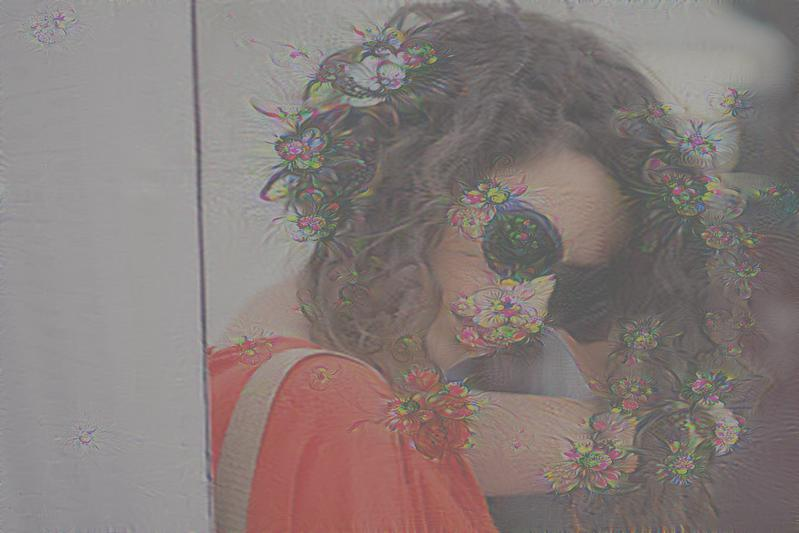

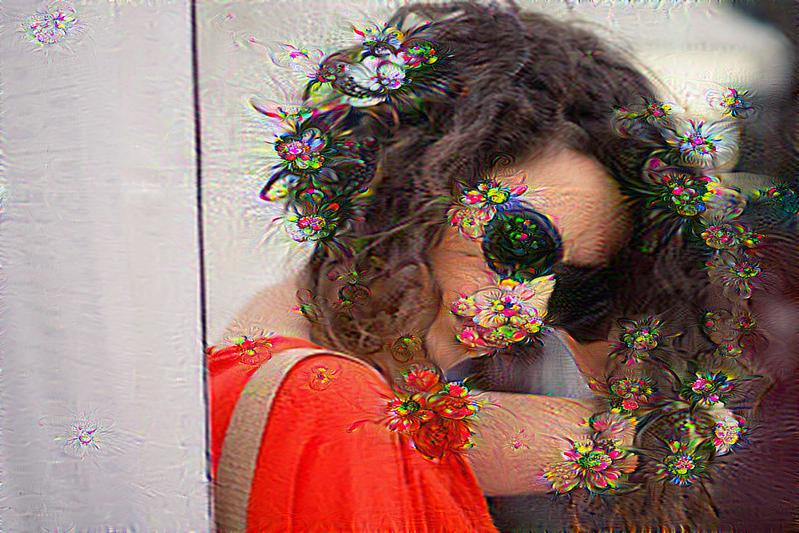

In [54]:
show(normalize(output_image))
show(output_image)